# 0. Import Modules and Setup Global Variables

In [4]:
import cv2, os
import numpy as np
import math as m
from matplotlib import pyplot as plt
%matplotlib inline
print(os.getcwd())

C:\Users\Hai\Documents\UQ\UQ 2022 - Sixth Year\METR4911_ML_Python\MaskRCNN-Notebook


In [5]:
############################ Global variables used in object_detection_mask() function ############################
# Fruit/Vegetable/Object Parameters
# coco_labels.txt, Labels for fruit/vegetable (6 labels)
LABELS = {0: "Person", 51: "Banana", 52: "Apple", 54: "Orange", 55: "Broccoli", 56: "Carrot"}

# Color in BGR in CV2 not RGB, match color with object's color in object_detection_mask() function
COLORS = {"Person": (179,179,255), "Banana": (72,216,255), "Apple": (0,8,255), 
         "Carrot": (33,145,237), "Orange": (0,126,255), "Broccoli": (0,255,74)}

# Object Detect Mask and Score Threshold in object_detection_mask() function
MASK_THRESHOLD = 0.65
SCORE_THRESHOLD = 0.5

############################ Global variables used in Item() and Finger(Item) class ############################
# TODO: Adjust the volume cm3 based on shape of item (need to update from testing the mass obtained vs real life mass)
ITEM_VOLUME_ADJUSTMENT = {"Banana": 1.0, "Apple": 1.0, "Carrot": 1.0, "Orange": 1.0, "Broccoli": 1.0}

# Shape Category [different shape will have their own volume equation]
SPHERE_SHAPE = ['Apple', 'Orange']
BANANA_SHAPE = ['Banana']
CARROT_SHAPE = ['Carrot']
BROCCOLI_SHAPE = ['Broccoli']

# TODO: Density (g/cm3) [Refer to excel sheet]
APPLE_DENSITY = 0.53
BANANA_DENSITY = 0.63
ORANGE_DENSITY = 0.76
CARROT_DENSITY = 1     # TODO: need to find out
BROCCOLI_DENSITY = 1   # TODO: need to find out

# Calories per gram [Refer to excel sheet]
APPLE_CONVERT_TO_CALORIE = 52 / 100        # 52 calorie per 100 g
BANANA_CONVERT_TO_CALORIE = 89 / 100       # 89 calorie per 100 g
ORANGE_CONVERT_TO_CALORIE = 47 / 100       # 47 calorie per 100 g
CARROT_CONVERT_TO_CALORIE = 41 / 100       # 41 calorie per 100 g
BROCCOLI_CONVERT_TO_CALORIE = 34 / 100     # 34 calorie per 100 g

# Finger Size (cm) [my left index finger size]
INDEX_FINGER_WIDTH = 1.48    # 14.8mm
INDEX_FINGER_HEIGHT = 1.185  # 11.85mm

########################### Window Parameters ###########################
# Input Resize Image for CNN input
IMG_WIDTH, IMG_HEIGHT  = (640, 480)

# Define plot size for all plots
plt.rcParams['figure.figsize'] = [6.4*1.75, 4.8*1.75]

# 1. Load Mask RCNN

In [6]:
# Get file path of weights(.pb) and config (.pbtxt)
frozen_pb = os.path.join("cv_dnn", "mask_rcnn_inception_v2_coco_2018_01_28", "frozen_inference_graph.pb")
pb_txt = os.path.join("cv_dnn", "mask_rcnn_inception_v2_coco_2018_01_28.pbtxt")

print("Weights:", frozen_pb)
print("Config:", pb_txt)

# Load the weights and the config of Mask RCNN
net = cv2.dnn.readNetFromTensorflow(frozen_pb, pb_txt)

Weights: cv_dnn\mask_rcnn_inception_v2_coco_2018_01_28\frozen_inference_graph.pb
Config: cv_dnn\mask_rcnn_inception_v2_coco_2018_01_28.pbtxt


## 1.1 Object Detection and Mask Segmentation Function

In [7]:
""" 
    Modified Source code from: https://www.youtube.com/watch?v=8m8m4oWsp8M
    YouTube Title: Instance Segmentation MASK R-CNN | with Python and Opencv
    YouTube Name: Pysource
    YouTube Date: May 18, 2021
"""
def object_detection_mask(img):
    """
    Passes the img into the MaskRCNN model to get the object detection boxes and its masks segmentation img.
    
        Parameters:
                    img (numpy.ndarray): Original image

        Returns:
                    img (numpy.ndarray): Image with object detection boxes+labels drawn on top
                    black_image (numpy.ndarray): Image segmentation mask of each detected object
                    box_list (list: numpy.ndarray): List of detected boxes
    """
    height, width, _ = img.shape  # (row, column)
    box_list = []
    
    ########################### Generate random colors and create black image ###########################
    black_image = np.zeros((height, width, 3), np.uint8)
    
    ########################### Detect objects ###########################
    blob = cv2.dnn.blobFromImage(img, swapRB=True)  # Get blob of input image
    net.setInput(blob)
    
    # boxes.shape (1,1,100,7),  mask.shape (100,90,15,15)
    boxes, masks = net.forward(["detection_out_final", "detection_masks"])  # Actual prediction (takes time)
    detection_count = boxes.shape[2]  # number of objects detected, 100 is the limit
    
    ############################ For each objects detected, draw box and mask ###########################
    for i in range(detection_count):
        # box [0,label,confidence,x1,y1,x2,y2] coods are normalised to 0-1 so multiply 
        #     the coods with image's width and height
        box = boxes[0, 0, i]
        class_id = int(box[1])  # Label/Class number, refer to coco_labels.txt
        score = box[2]          # Confidence percentage
        
        # If score below (is part of label) or not part of labels want to detect skip
        if (class_id not in LABELS) or (score < SCORE_THRESHOLD):
            continue

        color = COLORS[LABELS[class_id]] # Color of object, defined in section 0
                
        ############################ Get Box Coordinates and Draw Box and Label ############################
        x = int(box[3] * width)    # Top left
        y = int(box[4] * height)   # Top left
        x2 = int(box[5] * width)   # Bottom right
        y2 = int(box[6] * height)  # Bottom right
        
        new_box = list(box.copy())
        new_box[3:] = (x, y, x2, y2)
        new_box[1] = LABELS[int(class_id)]
        box_list.append(new_box) # Get the box data
        
        # Draw rectangle box around detected object
        line_thickness = 2
        pad_x, pad_y = 2, 4
        cv2.rectangle(img, (x,y), (x2,y2), color, line_thickness) 
        
        # Draw Label's rectangle box and Add Text
        label_box_height = 20   # Change Height of Label Box
        label_box_width = 75    # Change Width of Label Box
        
        # Positions for box
        label_x = x - line_thickness // 2 
        label_y = y - label_box_height
        label_x2 = x + label_box_width
        label_y2 = y
        
        # Draw Box
        cv2.rectangle(img, (label_x,label_y), (label_x2,label_y2), color, cv2.FILLED)
        
        # Draw Text
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(img, LABELS[class_id], (x + pad_x, y - pad_y), font, 0.5, (0,0,0), 1, cv2.LINE_AA)
        
        ############################ Get the mask ############################
        roi = black_image[y: y2, x: x2]
        
        roi_height, roi_width, _ = roi.shape
        mask = masks[i, int(class_id)]  # mask.shape -> (15, 15)
        mask = cv2.resize(mask, (roi_width, roi_height))    # Resize from (15,15) to actual size
        
        # 0.5 is threshold of confidence score of each pixel? so over 0.5 becomes 255 and 0 otherwise
        _, mask = cv2.threshold(mask, MASK_THRESHOLD, 255, cv2.THRESH_BINARY)
        
        ############################ Get Mask Coordinates ############################
        # Extract boundary of object
        contours, _ = cv2.findContours(np.array(mask, np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)         
        
        ############################ Draw and Fill Polygons ############################
        for cnt in contours:
            cv2.fillPoly(roi, [cnt], color)
    
    ############################ Display output image on computer ############################
    cv2.imshow("Frame", img)
    cv2.imshow("Black Image", black_image)
    
    return (img.copy(), black_image.copy(), box_list)

## 1.2 Item and Finger Class

In [11]:
class Item:
    """
    Object detected in images with their full information.
    """
    def __init__(self, full_original_img, full_segmentation_img, box):
        # Hard Coded Parameters
        self.window_x, self.window_y = 0, 0 # window position for 3 images function
        self.alpha = 0.4  # Transparency factor for mask overlay
        
        # Full original image
        self.full_original_img = full_original_img
        
        # Full segmentation image
        self.full_segmentation_img = full_segmentation_img
        
        # box [0,label,confidence,x1,y1,x2,y2]
        self.box = box  
        
        # Extract box values
        # eg. box = [0.0, 'Person', 0.95590365, 1, 199, 249, 331]
        self.name = box[1]
        self.confidence = box[2]
        self.x1, self.y1 = box[3:5]
        self.x2, self.y2 = box[5:]
        
        # Object image itself
        self.object_itself = self.full_original_img[self.y1:self.y2, self.x1:self.x2].copy()
        
        # Object image segment (Color and Grey) itself
        self.object_segmentation_img = self.full_segmentation_img[self.y1:self.y2, self.x1:self.x2].copy()
        self.object_itself_grey = cv2.cvtColor(self.object_segmentation_img, cv2.COLOR_BGR2GRAY)
        
        # Object Window's pixel height and width
        self.object_window_height = self.object_itself_grey.shape[0]
        self.object_window_width = self.object_itself_grey.shape[1]

        # Third parameter is image object detect box
        self.object_mask_overlay = cv2.addWeighted(self.object_segmentation_img,
                                       self.alpha, self.object_itself, 1 - self.alpha, 0)
        
        # Calculate number of pixels in grey image of object (SIDE)
        self.num_pixels = cv2.countNonZero(self.object_itself_grey)
            
        # Initialize after getting calibration pixel per cm (finger)
        self.pixels_per_cm = None
        self.pixels_per_1cm_square = None
        
        # Update after getting calibration pixel per cm (finger)
        self.side_pixel_area = None
        self.side_area = None
        
        # Volume of item based on shape of item
        self.volume_side = None
        self.volume_top = None
        
        # Initialize to None, to be calculated
        self.mass = None
        self.calorie = None
        
    def get_name(self):
        return self.name
    
    def get_confidence(self):
        return self.confidence
    
    def get_rectangle_coods_top_left(self):
        return self.x1, self.y1
    
    def get_rectangle_coods_bot_right(self):
        return self.x2, self.y2
    
    def get_num_pixels(self):
        return self.num_pixels
    
    # Side
    def get_item_area_cm2(self):
        return self.item_pixels_area_cm2
    
    def get_volume_side_cm3(self):
        return self.volume_side
    
    def get_mass(self):
        # Comment the print function in demo
        print(f'Mass of {self.name}: {round(self.mass)} grams')
        return self.mass
    
    def get_calorie(self):
        # Comment the print function in demo
        print(f'Calories of {self.name}: {round(self.calorie)} calories')
        return self.calorie
    
    # Need to show orignal image, not the box stuff and label stuff
    def show_original_image(self):
        cv2.imshow("Original Image", self.full_original_img)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        
    def show_segmentation_image(self):
        cv2.imshow("Segmentation Image", self.full_segmentation_img)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    
    def show_original_object(self):
        cv2.imshow("Object Image", self.object_itself)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        
    def show_color_segment_object(self):
        cv2.imshow("Object Segment Image", self.object_segmentation_img)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        
    def show_grey_object(self):
        cv2.imshow("Object Grey Image", self.object_itself_grey)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    
    def show_maskoverlay_object(self):
        cv2.imshow("Object Mask Overlay Image", self.object_mask_overlay)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        
    def show_3_images(self):
        # Display window of object itself
        window_name_object = f"Object Image: {self.name}"
        cv2.imshow(window_name_object, self.object_itself)
        cv2.moveWindow(window_name_object, self.window_x, self.window_y)

        ### Display window of the image segmentaiton of object itself
        window_name_segment = f"Image Segmentation: {self.name}"
        cv2.imshow(window_name_segment, self.object_segmentation_img)
        cv2.moveWindow(window_name_segment, self.window_x + (self.x2-self.x1), self.window_y)

        # Display window of the mask overlay
        window_name_overlay = f"Mask Overlay: {self.name}"
        cv2.imshow(window_name_overlay, self.object_mask_overlay)
        cv2.moveWindow(window_name_overlay, self.window_x + (self.x2-self.x1)*2, self.window_y)
        
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    # Update pixels per cm and 1cm2 from finger item
    def set_calibration_pixel_finger(self, finger_pixel_per_cm, finger_pixels_per_1cm_square):
        self.pixels_per_cm = finger_pixel_per_cm
        self.pixels_per_1cm_square = finger_pixels_per_1cm_square
        
        # Update item's cm2 area
        self.item_pixels_area_cm2 = self.num_pixels / self.pixels_per_1cm_square
        
    # TODO: Set for side and top view and other shapes
    def set_volume_side(self):
#         SPHERE_SHAPE = ['Apple', 'Orange']     [Volume of sphere]
#         BANANA_SHAPE = ['Banana']
#         CARROT_SHAPE = ['Carrot']
#         BROCCOLI_SHAPE = ['Broccoli']
        
        # Apple, Orange (No need to calculate top side)
        if self.name in SPHERE_SHAPE:            
            self.radius = (self.item_pixels_area_cm2 / m.pi)**0.5  # Area of circle equation
            self.volume_side = ITEM_VOLUME_ADJUSTMENT[self.name] * (4/3) * self.radius * self.item_pixels_area_cm2 # cm^3
    
    # TODO: Need side and top volume but for sphere shape, can calculate straight away
    def set_mass_and_calory(self):
        # Convert volume (cm^3) -> mass (g) -> calories (cal/g)
        # mass = density * volume
        
        # Apple, Orange (No need to calculate top side)
        if self.name in SPHERE_SHAPE: 
            if self.name == 'Apple':
                self.mass = APPLE_DENSITY * self.volume_side
                self.calorie = APPLE_CONVERT_TO_CALORIE * self.mass
                
            elif self.name == 'Orange':
                self.mass = ORANGE_DENSITY * self.volume_side
                self.calorie = ORANGE_CONVERT_TO_CALORIE * self.mass
        
        
########################### Finger Class ###########################
class Finger(Item):
    def __init__(self, full_original_img, full_segmentation_img, box):
        super().__init__(full_original_img, full_segmentation_img, box)
        
        # Variables used to find number of pixels of finger's height (from inner line),
        # Outer line (Line1) is from finger tip, inner line (Line2) is ideally from index finger's joint
        
        # Offset x-direction ratio (window width) from outer to inner lines
        self.inner_line_offset_ratio = 0.1 
        
        # Ratio of window height threshold for outer line
        self.height_ratio_threshold = 0.05 
        
        # Minimum pixel threshold for outer line 
        self.vertical_line_pixel_threshold = round(person_box_height * self.height_ratio_threshold)
        
        # Make grey copy to draw lines on (debugging purposes)
        self.finger_2_lines = self.object_itself_grey.copy()
    
        ### Scan vertical line from right to left, stop when the vertical line contains some pixel colors
        for x in range(self.object_window_width, -1, -1):
            single_vertical_line_pixel = np.count_nonzero(self.finger_2_lines[:, x:x+1])
            if single_vertical_line_pixel > self.vertical_line_pixel_threshold:
                self.x_start = x
                break

        # First line touch edge of finger
        self.line1_start = (self.x_start, 0)
        self.line1_end = (self.x_start, self.object_window_height)
        cv2.line(self.finger_2_lines, self.line1_start, self.line1_end, (255,255,255), 1)  # Draw outer line

        # Second line offset to the left by window ratio to get location of finger height
        self.x_offset = round(self.object_window_width * self.inner_line_offset_ratio)
        self.line2_start = (self.line1_start[0] - self.x_offset, 0)
        self.line2_end = (self.line1_start[0] - self.x_offset, self.object_window_height)
        cv2.line(self.finger_2_lines, self.line2_start, self.line2_end, (255,255,255), 1)  # Draw inner line

        # Get number of pixels of finger in inner line
        self.inner_single_vertical_line_pixel = np.count_nonzero(
            self.object_itself_grey.copy()[:, self.line2_start[0]:self.line2_start[0]+1])
        
        # Number of pixels per 1cm 
        self.pixels_length_per_cm_FINGER = round(self.inner_single_vertical_line_pixel / INDEX_FINGER_WIDTH)

        # Number of pixels square: 1cm * 1cm = 1cm2
        self.pixels_per_cm_squared_FINGER = self.pixels_length_per_cm_FINGER * self.pixels_length_per_cm_FINGER

        ########################### Show window - DEBUGGIN PURPOSES ###########################
#         cv2.imshow(window_name_segment, self.finger_2_lines)
#         cv2.waitKey(0)  
#         cv2.destroyAllWindows()
#         plt.imshow(cv2.cvtColor(box_person_img_mask, cv2.COLOR_BGR2RGB))

#         print("Window-Width:", self.object_window_width)
#         print("Window-Height:", self.object_window_height)
#         print("Vertical Line Width Point:", self.x_start)
#         print("Offset Width Vertical Line:", self.x_offset)
#         print("Vertical Lines Width Ratio Offset:", self.inner_line_offset_ratio, '\n')
#         print("Number of pixels in finger's height from inner vertical line:", self.inner_single_vertical_line_pixel) 
        
    def get_num_pixels_inner_vertical_line_finger(self):
        return self.inner_single_vertical_line_pixel
    
    def get_pixels_length_per_cm(self):
        return self.pixels_length_per_cm_FINGER
    
    def get_pixels_per_cm_squared(self):
        return self.pixels_per_cm_squared_FINGER
    
    def debugging_calibration(self):
        ## Show 1cm^2 rectangle overlay (***TESTING***)
        # Third parameter is image object detect box
        x1_square, y1_square = (0,0)
        x2_square, y2_square = (self.pixels_length_per_cm_FINGER, self.pixels_length_per_cm_FINGER)
        segment_calibration_square_test = self.full_segmentation_img.copy()
        
        cv2.rectangle(segment_calibration_square_test, (x1_square,y1_square),
                      (x2_square,y2_square), (0,255,0), cv2.FILLED)

        mask_overlay_calibration_square_test = cv2.addWeighted(segment_calibration_square_test, self.alpha,
                                                          object_detect_img, 1 - self.alpha, 0)

        cv2.imshow("1cm^2 calibration square", mask_overlay_calibration_square_test)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        
        plt.imshow(cv2.cvtColor(mask_overlay_calibration_square_test, cv2.COLOR_BGR2RGB))
        print("Number of pixels in 1cm line:", self.pixels_length_per_cm_FINGER)
        print("Number of pixels in 1cm x 1cm square:", self.pixels_per_cm_squared_FINGER)

# 2. Detect Static Image

## 2.1 Side Image 

In [12]:
# Load image
# img_file = "banana.d8fbcaf6-03f4-11ed-a1f3-95c0acd580f9.jpg"
# img_path = os.path.join("old_test_train_images_xml", "Fruit_Vegetable_15-July-22", "collectedimages", "banana", img_file)

img_file = "orange-finger-original.jpg"
img_path = os.path.join("WebCam_images", img_file)

print(img_path)

WebCam_images\orange-finger-original.jpg


Width: 640
Height: 480


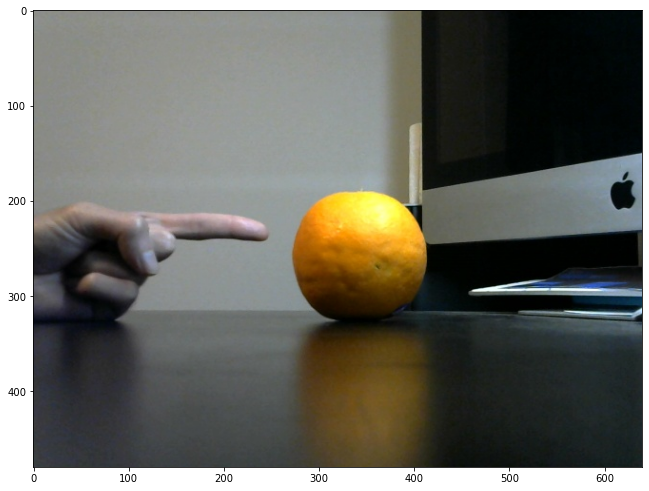

In [13]:
# Read image and resize image to (640, 480) or other dimensions
img = cv2.imread(img_path)
img = cv2.resize(img, (IMG_WIDTH,IMG_HEIGHT), interpolation = cv2.INTER_AREA)

original_img = img.copy() # Vanilla pure image, no overlays, boxes, labels, etc
overlay = img.copy() # For mask overlay
height, width, _ = img.shape

# 0 = open until any key is pressed, then close, any other number, in milliseconds, opens window in that duration
cv2.imshow("Image ({},{})".format(width, height), img)
cv2.waitKey(0)  
cv2.destroyAllWindows()

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Inline show image in notebook

print("Width:", width)
print("Height:", height)

## 2.2 Top Image 